In [158]:
import os

# Cache
from joblib import Memory

# Data
import numpy as np
import pandas as pd

# Stats
import scipy.stats as stats
from scipy.stats import spearmanr, linregress, entropy, kruskal
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import pingouin as pg

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import networkx as nx

# CDSS
from ai_cdss.data_loader import DataLoader
from ai_cdss.data_processor import DataProcessor
from ai_cdss.ppf import load_protocol_attributes
from ai_cdss.constants import *

from cdss_utils import expand_session, check_session, safe_merge, filter_study_range, get_confidence_intervals, generate_patient_protocol_report

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
    

In [2]:
memory = Memory(location='cache_dir', verbose=0)

@memory.cache
def load_session_cached(patient_list):
    return check_session(loader.load_session_data(patient_list=patient_list))

@memory.cache
def load_timeseries_cached(patient_list):
    return loader.load_timeseries_data(patient_list=patient_list)

SAVE_DATA = True
EXPAND = False

# NEST DATA
nest_patient = [
    775,  787,  788, 1123, 1169, 1170, 1171, 1172, 1173, 1983, 2110, 2195,
    2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 3081, 3229, 3318, 3432
]

rgs_mode = "app"
scoring_weights = [1, 1, 1]
ewma_alpha = 0.2

n = 12
days = 7
protocols_per_day = 5

loader = DataLoader(rgs_mode=rgs_mode)
processor = DataProcessor(weights=scoring_weights, alpha=ewma_alpha)

# Load Data
session = load_session_cached(nest_patient)
timeseries = load_timeseries_cached(nest_patient)
ppf = loader.load_ppf_data(patient_list=nest_patient)

# ppf = loader.load_ppf_data(patient_list=nest_patient)
protocol_similarity = loader.load_protocol_similarity()
protocol_metrics = loader.load_protocol_init()

# Process Data
session = session.dropna(subset=["ADHERENCE"])
ts = processor.aggregate_dms_by_time(timeseries)
ts = ts.sort_values(by=BY_PPST)

# Merge
data = safe_merge(session, ts, on=BY_PPS, how="inner", left_name="session", right_name="ts")
nest_data = safe_merge(data, ppf, on=BY_PP, how="left", left_name="session", right_name="ppf")
nest_data.sort_values(by=BY_PPST, inplace=True)

# Expand with non-performed sessions
# nest_data_all = expand_session(nest_data)
study_data = nest_data.groupby('PATIENT_ID', group_keys=False).apply(filter_study_range)
study_data['DAY_INDEX'] = study_data.groupby('PATIENT_ID')['SESSION_DATE'].transform(
    lambda x: (x - x.min()).dt.days
)

INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:Protocol similarity data loaded successfully.
INFO:ai_cdss.data_loader:Protocol initialization data loaded successfully.
/tmp/ipykernel_3800182/3775478127.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  study_data = nest_data.groupby('PATIENT_ID', group_keys=False).apply(filter_study_range)


In [27]:
clinical_scores = pd.read_csv("data/nest_T01.csv")
clinical_scores['DIFF'] = clinical_scores['T1'] - clinical_scores['T0']

protocol_attrs = load_protocol_attributes(file_path="data/protocol_attributes_type.csv")
session_data = study_data.drop_duplicates(subset=BY_ID)

File copied to default directory: /home/dav/.ai_cdss/data/protocol_attributes_type.csv


In [4]:
df = session_data[BY_ID + ["AGE", "STATUS", "DAY_INDEX"]]
df = df[df['STATUS'] != "NOT_PERFORMED"]  # skip this if not available

In [5]:
# Step 3: Sort data
sessions_df = df.sort_values(by=['PATIENT_ID', 'DAY_INDEX'])

# Step 4: For each patient, mark if protocol is new (cumulative)
def compute_novelty(group):
    seen_protocols = set()
    novelty_flags = []
    for protocol in group['PROTOCOL_ID']:
        if protocol not in seen_protocols:
            novelty_flags.append(1)  # New protocol
            seen_protocols.add(protocol)
        else:
            novelty_flags.append(0)  # Already seen
    group['IS_NEW_PROTOCOL'] = novelty_flags
    return group

sessions_df = sessions_df.groupby('PATIENT_ID', group_keys=False).apply(compute_novelty)


/tmp/ipykernel_3800182/3156847180.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sessions_df = sessions_df.groupby('PATIENT_ID', group_keys=False).apply(compute_novelty)


In [6]:
# Step 5: Aggregate novelty per patient per day
novelty_per_day = sessions_df.groupby(['PATIENT_ID', 'DAY_INDEX']).agg(
    total_protocols=('PROTOCOL_ID', 'count'),
    new_protocols=('IS_NEW_PROTOCOL', 'sum')
).reset_index()

# Step 6: Compute novelty rate
novelty_per_day['novelty_rate'] = novelty_per_day['new_protocols'] / novelty_per_day['total_protocols']

### Novelty correlation

In [7]:
import numpy as np
from scipy.integrate import simps
from scipy.optimize import curve_fit


In [8]:
sessions_df = sessions_df.sort_values(by=["PATIENT_ID", "DAY_INDEX"])

In [9]:
# Prepare a new dataframe to collect patient-level summary metrics
summary_df = pd.DataFrame(index=sessions_df['PATIENT_ID'].unique())

# Step 1: Total protocols per patient
summary_df['total_protocols'] = sessions_df.groupby('PATIENT_ID').size()

# Step 2: Unique protocols per patient
summary_df['unique_protocols'] = sessions_df.groupby('PATIENT_ID')['PROTOCOL_ID'].nunique()

# Step 3: Cumulative novelty rate
summary_df['cumulative_novelty'] = summary_df['unique_protocols'] / summary_df['total_protocols']

# Step 4: Mean daily novelty rate
mean_daily_novelty = novelty_per_day.groupby('PATIENT_ID')['novelty_rate'].mean()
summary_df['mean_daily_novelty'] = mean_daily_novelty

# Step 5: Novelty AUC (area under the novelty curve)
def compute_auc(group):
    x = group['DAY_INDEX']
    y = group['novelty_rate']
    return simps(y, x)

novelty_auc = novelty_per_day.groupby('PATIENT_ID').apply(compute_auc)
summary_df['novelty_auc'] = novelty_auc

# Step 6: Early-phase novelty (mean of first N days, e.g., 3)
N = 7
early_phase_novelty = novelty_per_day[novelty_per_day['DAY_INDEX'] <= N].groupby('PATIENT_ID')['novelty_rate'].mean()
summary_df['early_phase_novelty'] = early_phase_novelty

# Step 7: Decay rate of novelty (fit exponential decay per patient)
def exponential_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

def fit_decay(group):
    x = group['DAY_INDEX']
    y = group['novelty_rate']
    if len(x) > 2:  # Need at least 3 points to fit
        try:
            popt, _ = curve_fit(exponential_decay, x, y, bounds=(0, [1., 1., 1.]))
            return popt[1]  # Decay rate parameter 'b'
        except RuntimeError:
            return 0
    else:
        return 0

decay_rates = novelty_per_day.groupby('PATIENT_ID').apply(fit_decay)
summary_df['novelty_decay_rate'] = decay_rates

# Final summary
# print(summary_df)


/tmp/ipykernel_3800182/3754285941.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  novelty_auc = novelty_per_day.groupby('PATIENT_ID').apply(compute_auc)
/tmp/ipykernel_3800182/3754285941.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  decay_rates = novelty_per_day.groupby('PATIENT_ID').apply(fit_decay)


In [10]:
summary_df = summary_df.reset_index().rename(columns={"index": "PATIENT_ID"})

In [11]:
features = summary_df.merge(clinical_scores, on=["PATIENT_ID"], how="left")
features_all = features.merge(sessions_df[["PATIENT_ID", "AGE"]].drop_duplicates(), on=["PATIENT_ID"], how="left")
features_all.drop_duplicates(subset = "PATIENT_ID", inplace=True)

In [12]:
features_all

,PATIENT_ID,total_protocols,unique_protocols,cumulative_novelty,mean_daily_novelty,novelty_auc,early_phase_novelty,novelty_decay_rate,T0,T1,DIFF,AGE
0,775,37,5,0.135135,0.202222,2.532143,0.625,0.124521,61,62,1,88
1,787,96,5,0.052083,0.083333,3.375000,0.416667,0.453120,42,55,13,59
2,788,93,6,0.064516,0.032051,0.611111,0.119048,0.812174,53,57,4,44
3,1123,68,5,0.073529,0.032051,0.277778,0.119048,1.000000,56,54,-2,74
4,1169,72,5,0.069444,0.062745,-1.116667,0.166667,0.816591,12,17,5,74
6,1170,25,4,0.160000,0.152778,3.267460,0.5,0.132720,58,60,2,77
7,1171,30,6,0.200000,0.181818,4.861111,0.666667,0.271147,39,43,4,52
8,1172,20,5,0.250000,0.205882,9.027778,0.625,0.210343,63,64,1,56
9,1173,9,3,0.333333,0.277778,4.125000,0.333333,1.000000,62,64,2,69
10,1983,36,1,0.027778,0.019231,-0.333333,0.125,1.000000,25,24,-1,71


## Visualization

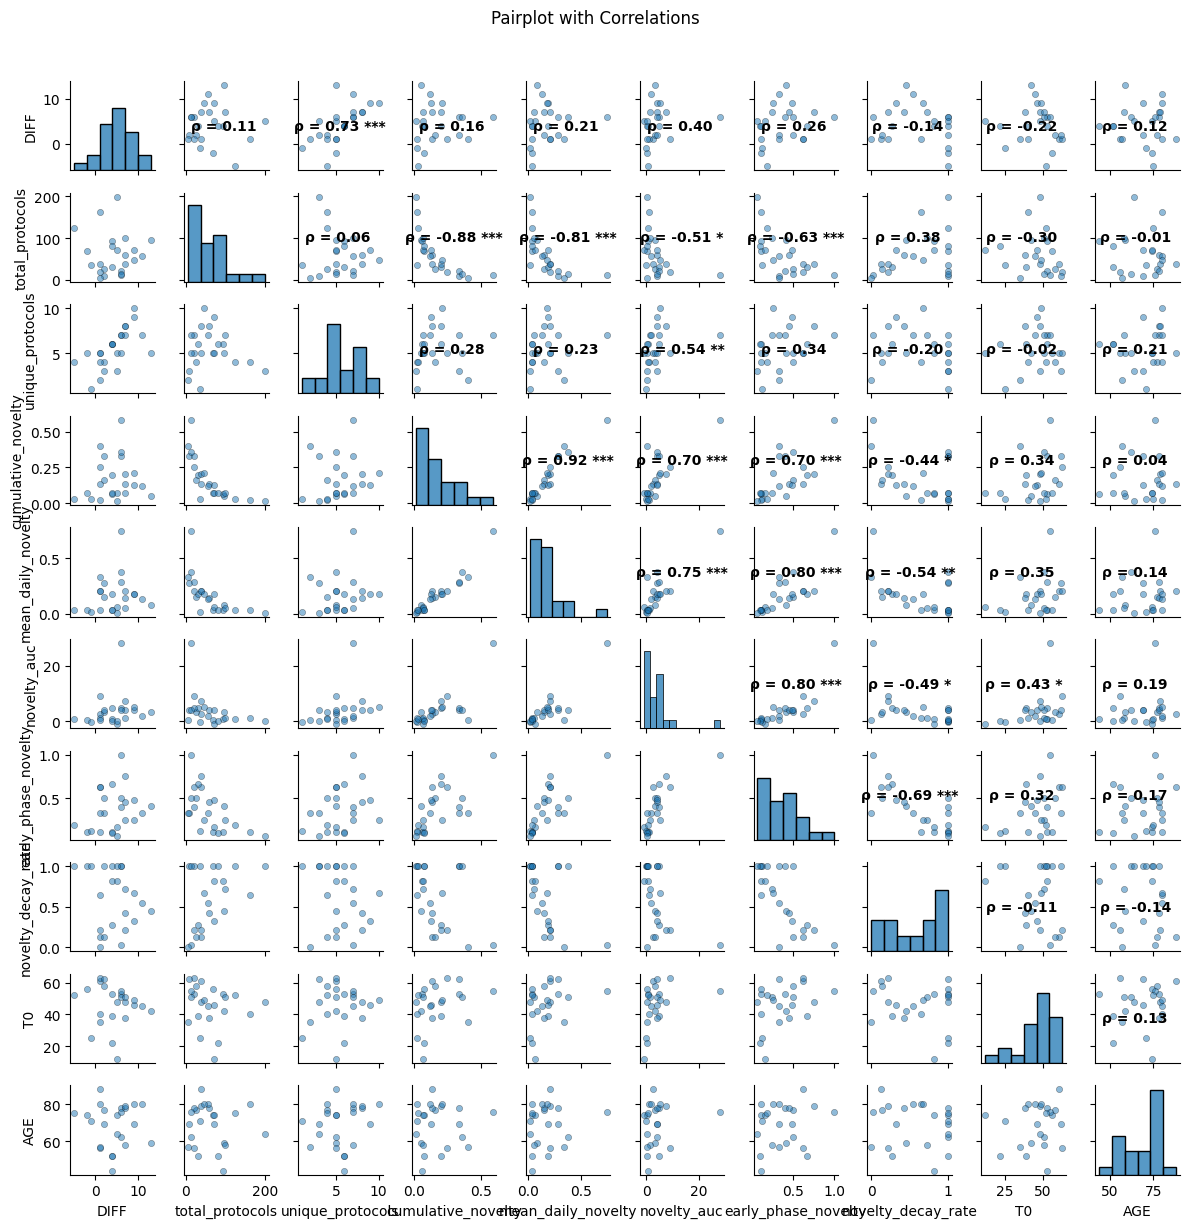

In [13]:
vars_to_plot = ["DIFF", "total_protocols", "unique_protocols", "cumulative_novelty", "mean_daily_novelty", "novelty_auc", "early_phase_novelty", "novelty_decay_rate", "T0", "AGE"]
n_vars = len(vars_to_plot)
desired_total_height = 12
height = desired_total_height / n_vars

def corrfunc(x, y, **kws):
    r, p = spearmanr(x, y)
    ax = plt.gca()

    # Significance stars
    if p < 0.001:
        stars = '***'
    elif p < 0.01:
        stars = '**'
    elif p < 0.05:
        stars = '*'
    else:
        stars = ''

    ax.annotate(f'ρ = {r:.2f} {stars}',
                xy=(0.5, 0.5), xycoords=ax.transAxes,
                ha='center', va='center',
                fontsize=10, fontweight='bold')

# Plot
g = sns.pairplot(
    features_all[vars_to_plot],
    corner=False,
    plot_kws={'alpha': 0.5, 's': 20, 'edgecolor': 'k'},
    height=height,
    aspect=1  # keep square plots
)

# Map correlation function to upper triangle
g.map_upper(corrfunc)

plt.suptitle("Pairplot with Correlations", y=1.02)
plt.tight_layout()
plt.show()

In [17]:
model_clinical = smf.ols('DIFF ~ unique_protocols + mean_daily_novelty + T0', data=features_all)
result = model_clinical.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   DIFF   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     5.482
Date:                Mon, 14 Apr 2025   Prob (F-statistic):            0.00648
Time:                        13:45:03   Log-Likelihood:                -60.762
No. Observations:                  24   AIC:                             129.5
Df Residuals:                      20   BIC:                             134.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3843      2

### Effect on Protocol Mixture

 Another - more complicated - effect to look at is the mixture of protocols (M=motor; C=Cognition). Like when you do MMCC might have a different effect than MCMC, i.e. order effects


In [53]:
mapping_dict = {
    # "Motor": 1,
    # "Cognitive": -1,
    # "Balanced": 0
    "Motor": "M",
    "Cognitive": "C",
    "Balanced": "B"
}

In [44]:
order_df = session_data.sort_values(by=["PATIENT_ID","DAY_INDEX","SESSION_DATE"])

In [45]:
df_protocol = order_df[BY_ID + ["SESSION_DATE", "DAY_INDEX"]]

In [54]:
order_df = df_protocol.merge(protocol_attrs[["PROTOCOL_ID", "TYPE"]], on="PROTOCOL_ID")

In [55]:
order_df["TYPE_CODE"] = order_df["TYPE"].map(mapping_dict)

In [71]:
sequence_df = order_df.groupby(PATIENT_ID)["TYPE_CODE"].apply(lambda x: ''.join(x))
sequence_df.columns = ['PATIENT_ID', 'SEQUENCE']

In [120]:
def compute_sequence_features(seq):
    counts = {'M': seq.count('M'), 'C': seq.count('C'), 'B': seq.count('B')}

    transitions = sum(1 for i in range(1, len(seq)) if seq[i] != seq[i - 1])

    probs = [seq.count(c) / len(seq) for c in 'MCB' if seq.count(c) > 0]
    # print(probs)

    ent = entropy(probs, base=2) if len(probs) > 1 else 0
    
    return pd.Series({
        'N_sessions': len(seq),
        'N_transitions': transitions,
        'P_motor': counts['M'] / len(seq),
        'P_cognitive': counts['C'] / len(seq),
        'P_balanced': counts['B'] / len(seq),
        'Entropy': ent
    })

In [84]:
# Step 4: Merge with clinical outcomes
full_df = features_df.merge(clinical_scores, on='PATIENT_ID')

# Step 5: Kruskal-Wallis test by sequence pattern
grouped = full_df.groupby('TYPE_CODE')['DIFF'].apply(list)
kruskal_result = kruskal(*grouped)

In [85]:
kruskal_result

KruskalResult(statistic=23.0, pvalue=0.46077089055229187)

🟡 Not significant — no strong evidence that the exact sequence string (e.g., CCCB vs MMC) impacts outcome in this small sample.

In [86]:
# Step 6: Correlation with sequence features
correlation_results = {}
for col in ['N_transitions', 'P_motor', 'P_cognitive', 'P_balanced', 'Entropy']:
    r, p = spearmanr(full_df[col], full_df['DIFF'])
    correlation_results[col] = (r, p)

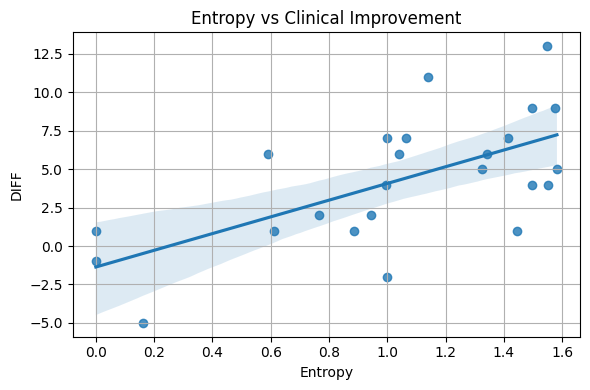

=== Kruskal-Wallis Test by SEQUENCE ===
Statistic: 23.000, p-value: 0.4608

=== Spearman Correlations ===
N_transitions: Spearman ρ = 0.380, p = 0.0668
P_motor: Spearman ρ = -0.534, p = 0.0072
P_cognitive: Spearman ρ = 0.566, p = 0.0039
P_balanced: Spearman ρ = 0.020, p = 0.9272
Entropy: Spearman ρ = 0.592, p = 0.0023


In [90]:
#  Plot: Entropy vs DIFF
plt.figure(figsize=(6, 4))
sns.regplot(data=full_df, x='Entropy', y='DIFF')
plt.title('Entropy vs Clinical Improvement')
plt.grid(True)
plt.tight_layout()
plt.show()

# Output all results
print("=== Kruskal-Wallis Test by SEQUENCE ===")
print(f"Statistic: {kruskal_result.statistic:.3f}, p-value: {kruskal_result.pvalue:.4f}")
print("\n=== Spearman Correlations ===")
for k, (r, p) in correlation_results.items():
    print(f"{k}: Spearman ρ = {r:.3f}, p = {p:.4f}")


In [99]:
df_all_reg = full_df.merge(features_all, on=["PATIENT_ID", "T0", "T1", "DIFF"], how="left")

In [199]:
model_clinical = smf.ols('DIFF ~ Entropy + T0', data=df_all_reg)
result = model_clinical.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   DIFF   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     7.748
Date:                Mon, 14 Apr 2025   Prob (F-statistic):            0.00302
Time:                        16:03:54   Log-Likelihood:                -61.331
No. Observations:                  24   AIC:                             128.7
Df Residuals:                      21   BIC:                             132.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0165      2.880      0.353      0.7

In [111]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# Step 1: Prepare the model design matrix
y, X = dmatrices('DIFF ~ Entropy + unique_protocols + Entropy:unique_protocols + T0', data=df_all_reg, return_type='dataframe')

# Step 2: Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                    feature        VIF
0                 Intercept  27.955768
1                   Entropy   4.673034
2          unique_protocols   8.396362
3  Entropy:unique_protocols  16.206798
4                        T0   1.109101


In [115]:
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from scipy import stats

# Prepare data
X = df_all_reg[['Entropy', 'unique_protocols', 'T0']]
y = df_all_reg['DIFF']

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ridge with cross-validation to choose alpha
ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5).fit(X_scaled, y)

# Predictions and residuals
y_pred = ridge.predict(X_scaled)
residuals = y - y_pred

# Degrees of freedom
n, p = X_scaled.shape
df = n - p - 1

# Mean Squared Error
mse = np.sum(residuals ** 2) / df

# Variance of coefficients
XTX_inv = np.linalg.inv(X_scaled.T @ X_scaled)
coef_var = np.diagonal(XTX_inv) * mse

# t-statistics
t_stats = ridge.coef_ / np.sqrt(coef_var)

# p-values
p_values = [2 * (1 - stats.t.cdf(np.abs(t), df)) for t in t_stats]

# Summary
ridge_summary = pd.DataFrame({
    'Coefficient': ridge.coef_,
    't-stat': t_stats,
    'p-value': p_values
}, index=X.columns)

print(f"Best alpha (penalty): {ridge.alpha_}")
print(ridge_summary)
print(f"R^2 Score: {ridge.score(X_scaled, y)}")


Best alpha (penalty): 4.9770235643321135
                  Coefficient    t-stat   p-value
Entropy              1.420666  1.736109  0.097926
unique_protocols     1.483483  1.805816  0.086022
T0                  -0.630406 -0.981990  0.337836
R^2 Score: 0.5197475030377364


In [117]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

# Prepare data
X = df_all_reg[['Entropy', 'unique_protocols']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance by PC1:", pca.explained_variance_ratio_[0])

# Regression with PC1 and T0
X_reg = np.hstack([X_pca, df_all_reg[['T0']].values])
y = df_all_reg['DIFF']

model = LinearRegression().fit(X_reg, y)
y_pred = model.predict(X_reg)
residuals = y - y_pred

# Degrees of freedom
n, p = X_reg.shape
df = n - p - 1

# Mean Squared Error
mse = np.sum(residuals ** 2) / df

# Variance of coefficients
XTX_inv = np.linalg.inv(X_reg.T @ X_reg)
coef_var = np.diagonal(XTX_inv) * mse

# t-statistics
t_stats = model.coef_ / np.sqrt(coef_var)

# p-values
p_values = [2 * (1 - stats.t.cdf(np.abs(t), df)) for t in t_stats]

# Summary
pcr_summary = pd.DataFrame({
    'Coefficient': model.coef_,
    't-stat': t_stats,
    'p-value': p_values
}, index=['PC1', 'T0'])

print(pcr_summary)
print(f"R^2 Score: {model.score(X_reg, y)}")

Explained variance by PC1: 0.8141438837994587
     Coefficient    t-stat   p-value
PC1     2.331880  4.829350  0.000090
T0     -0.064263 -4.971993  0.000064
R^2 Score: 0.5280136001679486


In [124]:
import pandas as pd
import numpy as np
from scipy.stats import entropy

def compute_markov_features(seq):
    # Define states
    states = ['M', 'C', 'B']
    total_sessions = len(seq)

    # Initialize transition counts
    transition_counts = pd.DataFrame(0, index=states, columns=states)

    # Count transitions
    for i in range(len(seq) - 1):
        from_state = seq[i]
        to_state = seq[i + 1]
        transition_counts.loc[from_state, to_state] += 1

    # Transition probabilities
    transition_probs = transition_counts.div(transition_counts.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

    # Flatten transition probabilities into features
    flat_transition_probs = transition_probs.stack().to_dict()

    # Entropy of transition probabilities
    transition_entropy_per_state = transition_probs.apply(
        lambda row: entropy([p for p in row if p > 0], base=2) if row.sum() > 0 else 0, axis=1
    )

    # Weighted average of transition entropy (by originating state counts)
    total_transitions = transition_counts.values.sum()
    if total_transitions > 0:
        weights = transition_counts.sum(axis=1) / total_transitions
        weighted_transition_entropy = (transition_entropy_per_state * weights).sum()
    else:
        weighted_transition_entropy = 0

    # Self-transition rates
    self_transitions = {f'Self_transition_{state}': transition_probs.loc[state, state] for state in states}

    # Specific transitions of interest
    key_transitions = {
        'P_M_to_C': transition_probs.loc['M', 'C'],
        'P_C_to_M': transition_probs.loc['C', 'M'],
        'P_M_to_B': transition_probs.loc['M', 'B'],
        'P_C_to_B': transition_probs.loc['C', 'B'],
    }

    # Compile features
    features = {
        'Total_sessions': total_sessions,
        'Total_transitions': total_transitions,
        'Weighted_transition_entropy': weighted_transition_entropy,
    }
    features.update(flat_transition_probs)
    features.update(self_transitions)
    features.update(key_transitions)

    return pd.Series(features)


In [125]:
markov_df = pd.DataFrame(sequence_df).copy()
markov_df = pd.concat([markov_df, markov_df['TYPE_CODE'].apply(compute_markov_features)], axis=1)

In [127]:

def plot_transition_matrix(seq):
    states = ['M', 'C', 'B']
    transition_counts = pd.DataFrame(0, index=states, columns=states)

    for i in range(len(seq) - 1):
        from_state = seq[i]
        to_state = seq[i + 1]
        transition_counts.loc[from_state, to_state] += 1

    transition_probs = transition_counts.div(transition_counts.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

    plt.figure(figsize=(6, 4))
    sns.heatmap(transition_probs, annot=True, cmap='Blues', fmt=".2f")
    plt.title('Transition Probability Matrix')
    plt.xlabel('To State')
    plt.ylabel('From State')
    plt.show()


In [134]:
markov_df = markov_df.merge(clinical_scores, on="PATIENT_ID")


=== Spearman Correlations with Clinical Improvement (DIFF) ===
Total_sessions: ρ = 0.115, p = 0.5927
Total_transitions: ρ = 0.115, p = 0.5927
Weighted_transition_entropy: ρ = 0.612, p = 0.0015
('M', 'M'): ρ = -0.306, p = 0.1459
('M', 'C'): ρ = 0.588, p = 0.0025
('M', 'B'): ρ = -0.081, p = 0.7073
('C', 'M'): ρ = 0.489, p = 0.0153
('C', 'C'): ρ = 0.558, p = 0.0046
('C', 'B'): ρ = 0.595, p = 0.0022
('B', 'M'): ρ = -0.145, p = 0.4998
('B', 'C'): ρ = 0.619, p = 0.0013
('B', 'B'): ρ = -0.003, p = 0.9893
Self_transition_M: ρ = -0.306, p = 0.1459
Self_transition_C: ρ = 0.558, p = 0.0046
Self_transition_B: ρ = -0.003, p = 0.9893
P_M_to_C: ρ = 0.588, p = 0.0025
P_C_to_M: ρ = 0.489, p = 0.0153
P_M_to_B: ρ = -0.081, p = 0.7073
P_C_to_B: ρ = 0.595, p = 0.0022
T0: ρ = -0.219, p = 0.3050
T1: ρ = 0.161, p = 0.4526

✅ Ridge Regression R²: 1.000
Coefficients: {'N_sessions': 0.00015598493111695585, 'N_transitions': -0.00017164470966412313, 'P_motor': 0.00010699207546132601, 'P_cognitive': -4.57814184520

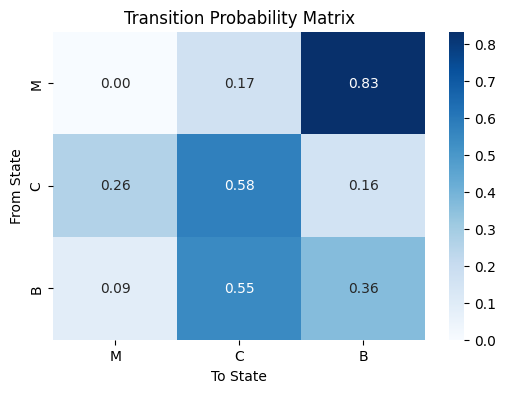

AttributeError: 'tuple' object has no attribute 'startswith'

In [146]:
# === Step 3: Correlation analysis ===

print("\n=== Spearman Correlations with Clinical Improvement (DIFF) ===")
for col in markov_df.columns:
    if col not in ['PATIENT_ID', 'TYPE_CODE', 'DIFF']:
        rho, pval = spearmanr(markov_df[col], markov_df['DIFF'])
        print(f"{col}: ρ = {rho:.3f}, p = {pval:.4f}")

# Optional: Export to DataFrame
correlations = [
    {'feature': col, 'spearman_rho': spearmanr(markov_df[col], markov_df['DIFF'])[0],
     'p_value': spearmanr(markov_df[col], markov_df['DIFF'])[1]}
    for col in markov_df.columns if col not in ['PATIENT_ID', 'TYPE_CODE', 'DIFF']
]
correlations_df = pd.DataFrame(correlations).sort_values(by='spearman_rho', ascending=False)


# === Step 4: Regression models ===

# Prepare features and target
predictors = [col for col in full_df.columns if col not in ['PATIENT_ID', 'TYPE_CODE', 'DIFF', 'Cluster']]
X = full_df.select_dtypes(include=[np.number])
y = full_df['DIFF']

# Fix column names to strings
X.columns = X.columns.map(str)

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ridge Regression
ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
ridge.fit(X_scaled, y)
print(f"\n✅ Ridge Regression R²: {ridge.score(X_scaled, y):.3f}")
print("Coefficients:", dict(zip(predictors, ridge.coef_)))

# Linear Regression (OLS)
ols = LinearRegression()
ols.fit(X_scaled, y)
print(f"\n✅ OLS Regression R²: {ols.score(X_scaled, y):.3f}")
print("Coefficients:", dict(zip(predictors, ols.coef_)))


# === Step 5: Visualize a sample transition matrix ===

def plot_transition_matrix(seq):
    states = ['M', 'C', 'B']
    transition_counts = pd.DataFrame(0, index=states, columns=states)

    for i in range(len(seq) - 1):
        from_state = seq[i]
        to_state = seq[i + 1]
        transition_counts.loc[from_state, to_state] += 1

    transition_probs = transition_counts.div(transition_counts.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

    plt.figure(figsize=(6, 4))
    sns.heatmap(transition_probs, annot=True, cmap='Blues', fmt=".2f")
    plt.title('Transition Probability Matrix')
    plt.xlabel('To State')
    plt.ylabel('From State')
    plt.show()

# Example plot
plot_transition_matrix(markov_df.iloc[0]['TYPE_CODE'])


# === Step 6: Clustering patients by transition patterns (optional) ===

X_cluster = markov_df[[col for col in markov_df.columns if col.startswith('Transition_prob')]]
kmeans = KMeans(n_clusters=2, random_state=42)
markov_df['Cluster'] = kmeans.fit_predict(X_cluster)

print(f"\n✅ Clustering done. Silhouette score: {silhouette_score(X_cluster, markov_df['Cluster']):.3f}")

# Visualize cluster distribution
sns.boxplot(data=full_df, x='Cluster', y='DIFF')
plt.title('Clinical Improvement by Cluster')
plt.show()

In [143]:
markov_df

,PATIENT_ID,TYPE_CODE,Total_sessions,Total_transitions,Weighted_transition_entropy,"(M, M)","(M, C)","(M, B)","(C, M)","(C, C)",...,Self_transition_M,Self_transition_C,Self_transition_B,P_M_to_C,P_C_to_M,P_M_to_B,P_C_to_B,T0,T1,DIFF
0,775,CCCBCCCCMBCCCMBCCMBBCCCBBCBMCMBBBCCMB,37.0,36.0,1.242679,0.000000,0.166667,0.833333,0.263158,0.578947,...,0.000000,0.578947,0.363636,0.166667,0.263158,0.833333,0.157895,61,62,1
1,787,BMCCBCMCCCBCMMCBCMCCMCBBBCMMMCBCBMBMMCMMMBCMBB...,96.0,95.0,1.442067,0.400000,0.375000,0.225000,0.562500,0.125000,...,0.400000,0.125000,0.130435,0.375000,0.562500,0.225000,0.312500,42,55,13
2,788,BCBMCBCBBMBBMMCBMBMMMMCMMBBCBMMCBBMMBMMMMCBMBM...,93.0,92.0,1.421254,0.431818,0.250000,0.318182,0.352941,0.058824,...,0.431818,0.058824,0.193548,0.250000,0.352941,0.318182,0.588235,53,57,4
3,1123,BBMMMBBMBMBMBMMBMBMMBBMBMBMBMBMMBBMBMBBMBMMBMB...,68.0,67.0,0.859880,0.272727,0.000000,0.727273,0.000000,0.000000,...,0.272727,0.000000,0.294118,0.000000,0.000000,0.727273,0.000000,56,54,-2
4,1169,CCCCCCMCCMMCCCMCCCCCCMCCCCCCMMMCCMCCCCMBBCMCBB...,72.0,71.0,1.059143,0.200000,0.600000,0.200000,0.272727,0.704545,...,0.200000,0.704545,0.666667,0.600000,0.272727,0.200000,0.022727,12,17,5
5,1170,BMMBBMBBMBBMMBBMBBBBBMBMB,25.0,24.0,0.909571,0.222222,0.000000,0.777778,0.000000,0.000000,...,0.222222,0.000000,0.533333,0.000000,0.000000,0.777778,0.000000,58,60,2
6,1171,CMMCMBCMBCMCBCBCMCBCMCBMCBCBMC,30.0,29.0,1.017578,0.111111,0.666667,0.222222,0.500000,0.000000,...,0.111111,0.000000,0.000000,0.666667,0.500000,0.222222,0.500000,39,43,4
7,1172,BMBBBBBBBBMBBBBBMBBB,20.0,19.0,0.586284,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.812500,0.000000,0.000000,1.000000,0.000000,63,64,1
8,1173,BBBBBMBBM,9.0,8.0,0.755230,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.714286,0.000000,0.000000,1.000000,0.000000,62,64,2
9,1983,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM,36.0,35.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25,24,-1


✅ Markov features extracted and merged with clinical outcome.

=== Spearman Correlations with Clinical Improvement (DIFF) ===
PATIENT_ID: ρ = 0.187, p = 0.3813
Total_sessions: ρ = 0.115, p = 0.5927
Total_transitions: ρ = 0.115, p = 0.5927
Weighted_transition_entropy: ρ = 0.612, p = 0.0015
Transition_prob_M_to_M: ρ = -0.306, p = 0.1459
Transition_prob_M_to_C: ρ = 0.588, p = 0.0025
Transition_prob_M_to_B: ρ = -0.081, p = 0.7073
Transition_prob_C_to_M: ρ = 0.489, p = 0.0153
Transition_prob_C_to_C: ρ = 0.558, p = 0.0046
Transition_prob_C_to_B: ρ = 0.595, p = 0.0022
Transition_prob_B_to_M: ρ = -0.145, p = 0.4998
Transition_prob_B_to_C: ρ = 0.619, p = 0.0013
Transition_prob_B_to_B: ρ = -0.003, p = 0.9893
Transition_count_M_to_M: ρ = -0.287, p = 0.1743
Transition_count_M_to_C: ρ = 0.557, p = 0.0047
Transition_count_M_to_B: ρ = 0.057, p = 0.7921
Transition_count_C_to_M: ρ = 0.535, p = 0.0070
Transition_count_C_to_C: ρ = 0.588, p = 0.0025
Transition_count_C_to_B: ρ = 0.660, p = 0.0004
Transitio

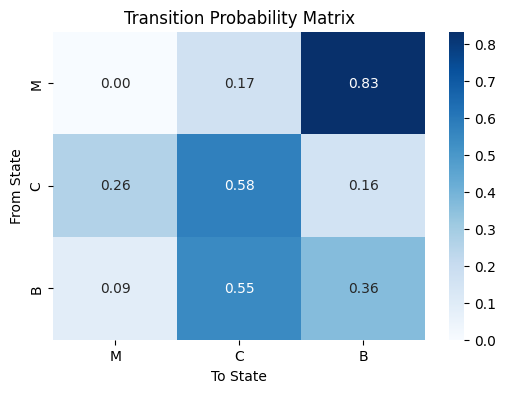

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



✅ Clustering done. Silhouette score: 0.312


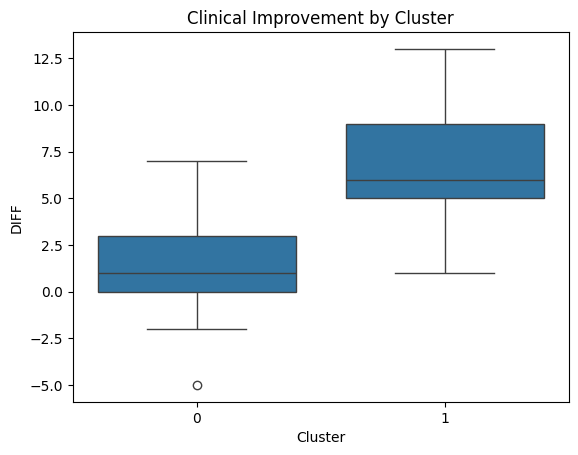


✅ All exports completed! Data ready for reporting.


In [151]:
import pandas as pd
import numpy as np
from scipy.stats import entropy, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# === Step 1: Markov feature extractor ===

def compute_markov_features(seq):
    states = ['M', 'C', 'B']
    total_sessions = len(seq)

    transition_counts = pd.DataFrame(0, index=states, columns=states)

    for i in range(len(seq) - 1):
        from_state = seq[i]
        to_state = seq[i + 1]
        transition_counts.loc[from_state, to_state] += 1

    transition_probs = transition_counts.div(transition_counts.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

    # Clean column names when flattening!
    flat_transition_probs = {
        f'Transition_prob_{from_state}_to_{to_state}': prob
        for (from_state, to_state), prob in transition_probs.stack().to_dict().items()
    }
    flat_transition_counts = {
        f'Transition_count_{from_state}_to_{to_state}': count
        for (from_state, to_state), count in transition_counts.stack().to_dict().items()
    }

    # Transition entropy
    transition_entropy_per_state = transition_probs.apply(
        lambda row: entropy([p for p in row if p > 0], base=2) if row.sum() > 0 else 0,
        axis=1
    )

    total_transitions = transition_counts.values.sum()
    if total_transitions > 0:
        weights = transition_counts.sum(axis=1) / total_transitions
        weighted_transition_entropy = (transition_entropy_per_state * weights).sum()
    else:
        weighted_transition_entropy = 0

    # Self-transitions
    self_transitions = {f'Self_transition_{state}': transition_probs.loc[state, state] for state in states}

    # Specific transitions of interest
    key_transitions = {
        'P_M_to_C': transition_probs.loc['M', 'C'],
        'P_C_to_M': transition_probs.loc['C', 'M'],
        'P_M_to_B': transition_probs.loc['M', 'B'],
        'P_C_to_B': transition_probs.loc['C', 'B'],
    }

    features = {
        'Total_sessions': total_sessions,
        'Total_transitions': total_transitions,
        'Weighted_transition_entropy': weighted_transition_entropy,
    }
    features.update(flat_transition_probs)
    features.update(flat_transition_counts)
    features.update(self_transitions)
    features.update(key_transitions)

    return pd.Series(features)

# === Step 2: Apply feature extraction ===

# Assuming you have:
# TYPE_CODE_df: columns = ['PATIENT_ID', 'TYPE_CODE']
# clinical_df: columns = ['PATIENT_ID', 'DIFF']

# Extract features
markov_df = pd.DataFrame(sequence_df).copy()
markov_df = pd.concat([markov_df, markov_df['TYPE_CODE'].apply(compute_markov_features)], axis=1)

# Merge with clinical outcome
markov_df = markov_df.merge(clinical_scores, on='PATIENT_ID')

print("✅ Markov features extracted and merged with clinical outcome.")

# === Step 3: Correlation analysis ===

print("\n=== Spearman Correlations with Clinical Improvement (DIFF) ===")
correlations = []
for col in markov_df.select_dtypes(include=[np.number]).columns:
    if col != 'DIFF':
        rho, pval = spearmanr(markov_df[col], markov_df['DIFF'])
        correlations.append({'feature': col, 'spearman_rho': rho, 'p_value': pval})
        print(f"{col}: ρ = {rho:.3f}, p = {pval:.4f}")

correlations_df = pd.DataFrame(correlations).sort_values(by='spearman_rho', ascending=False)

# === Step 4: Regression models (OLS + Ridge) ===

# Prepare predictors and target
X = markov_df.select_dtypes(include=[np.number]).drop(columns=['DIFF'])
y = markov_df['DIFF']

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ridge regression
ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
ridge.fit(X_scaled, y)

print(f"\n✅ Ridge Regression R²: {ridge.score(X_scaled, y):.3f}")
ridge_results = pd.DataFrame({
    'feature': X.columns,
    'ridge_coef': ridge.coef_
})

# OLS regression
ols = LinearRegression()
ols.fit(X_scaled, y)

print(f"\n✅ OLS Regression R²: {ols.score(X_scaled, y):.3f}")
ols_results = pd.DataFrame({
    'feature': X.columns,
    'ols_coef': ols.coef_
})

# === Step 5: Visualize a sample transition matrix ===

def plot_transition_matrix(seq):
    states = ['M', 'C', 'B']
    transition_counts = pd.DataFrame(0, index=states, columns=states)

    for i in range(len(seq) - 1):
        from_state = seq[i]
        to_state = seq[i + 1]
        transition_counts.loc[from_state, to_state] += 1

    transition_probs = transition_counts.div(transition_counts.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

    plt.figure(figsize=(6, 4))
    sns.heatmap(transition_probs, annot=True, cmap='Blues', fmt=".2f")
    plt.title('Transition Probability Matrix')
    plt.xlabel('To State')
    plt.ylabel('From State')
    plt.show()

# Example: plot for first patient
plot_transition_matrix(markov_df.iloc[0]['TYPE_CODE'])

# === Step 6: Clustering patients by transition patterns ===

X_cluster = markov_df[[col for col in markov_df.columns if col.startswith('Transition_prob')]]
kmeans = KMeans(n_clusters=2, random_state=42)
markov_df['Cluster'] = kmeans.fit_predict(X_cluster)

silhouette = silhouette_score(X_cluster, markov_df['Cluster'])
print(f"\n✅ Clustering done. Silhouette score: {silhouette:.3f}")

# Visualize improvement by cluster
sns.boxplot(data=markov_df, x='Cluster', y='DIFF')
plt.title('Clinical Improvement by Cluster')
plt.show()

# === Step 7: Optional — Export for reporting ===

# Export correlation table
correlations_df.to_csv("correlations_markov_features.csv", index=False)

# Export regression results
ridge_results.to_csv("ridge_regression_results.csv", index=False)
ols_results.to_csv("ols_regression_results.csv", index=False)

# Export final full DataFrame
markov_df.to_csv("markov_full_features.csv", index=False)

print("\n✅ All exports completed! Data ready for reporting.")

# === Step 8: Optional — Display full feature table interactively
# import ace_tools as tools; tools.display_dataframe_to_user(name="Markov Features and Clinical Outcome", dataframe=markov_df)


In [155]:
# Step 1: Characterize clusters
cluster_summary = markov_df.groupby('Cluster')[X_cluster.columns].agg(['mean', 'std']).T
# cluster_summary.columns = [f'Cluster_{col}_{stat}' for col, stat in cluster_summary.columns]

# Display summary
cluster_summary

Cluster                             0         1
Transition_prob_M_to_M mean  0.496207  0.148317
                       std   0.372347  0.159676
Transition_prob_M_to_C mean  0.022727  0.548609
                       std   0.075378  0.272143
Transition_prob_M_to_B mean  0.481066  0.303074
                       std   0.375639  0.269519
Transition_prob_C_to_M mean  0.032086  0.306572
                       std   0.106416  0.192505
Transition_prob_C_to_C mean  0.005348  0.416282
                       std   0.017736  0.257967
Transition_prob_C_to_B mean  0.053476  0.277146
                       std   0.177360  0.182666
Transition_prob_B_to_M mean  0.437894  0.198139
                       std   0.351644  0.261558
Transition_prob_B_to_C mean  0.017595  0.554972
                       std   0.058357  0.304035
Transition_prob_B_to_B mean  0.362692  0.169965
                       std   0.339520  0.195997

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_3800182/3924935913.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=markov_df, x='Cluster', y='DIFF', palette='Set2')
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



✅ Mann-Whitney U test between clusters: U = 19.5, p = 0.0027


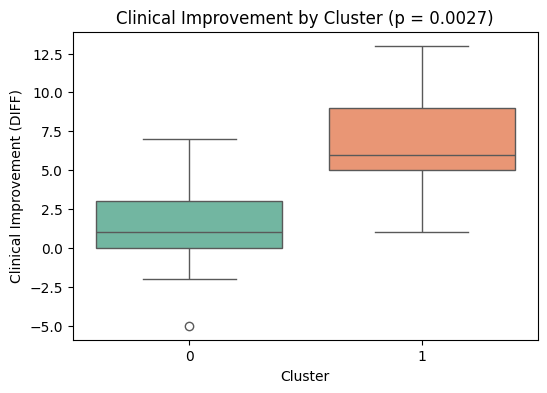

In [198]:
from scipy.stats import mannwhitneyu

group0 = markov_df[markov_df['Cluster'] == 0]['DIFF']
group1 = markov_df[markov_df['Cluster'] == 1]['DIFF']

u_stat, p_value = mannwhitneyu(group0, group1, alternative='two-sided')

print(f"\n✅ Mann-Whitney U test between clusters: U = {u_stat}, p = {p_value:.4f}")
plt.figure(figsize=(6, 4))
sns.boxplot(data=markov_df, x='Cluster', y='DIFF', palette='Set2')
plt.title(f'Clinical Improvement by Cluster (p = {p_value:.4f})')
plt.xlabel('Cluster')
plt.ylabel('Clinical Improvement (DIFF)')
plt.show()


In [188]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

def plot_transition_network_final_clean(transition_probs, title='Transition Network', save_path=None):
    G = nx.MultiDiGraph()

    states = ['M', 'C', 'B']
    for from_state in states:
        for to_state in states:
            prob = transition_probs.loc[from_state, to_state]
            if prob > 0:
                G.add_edge(from_state, to_state, weight=prob)

    # Custom layout (triangle style, clean readable)
    pos = {
        'M': np.array([0, 1]),
        'C': np.array([-1, -1]),
        'B': np.array([1, -1]),
    }

    plt.figure(figsize=(7, 7))
    ax = plt.gca()

    # Draw nodes (big node size for visibility, no overlap arrows)
    node_size = 2000
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='lightblue', edgecolors='black', linewidths=2)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=16, font_weight='bold')

    # Prepare edges
    cmap = cm.Blues
    edge_weights = nx.get_edge_attributes(G, 'weight')
    max_weight = max(edge_weights.values())

    for (u, v, key), weight in edge_weights.items():
        color = cmap(weight / max_weight)
        linewidth = weight * 8

        if u == v:
            # Self-loop: draw as manual arc above node
            loop_pos = pos[u] + np.array([0.0, 0.2])  # Offset above node
            circle = plt.Circle(loop_pos, 0.15, color=color, fill=False, linewidth=linewidth, linestyle='-', zorder=1)
            ax.add_patch(circle)
            # Label above the loop
            plt.text(loop_pos[0], loop_pos[1] + 0.2, f"{weight:.2f}", fontsize=12, ha='center', va='center')
        else:
            # Curve edges and shorten arrows to avoid node overlap
            rad = 0.25
            shrink = 0.15  # Reduces arrow tip to not overlap node

            nx.draw_networkx_edges(
                G, pos,
                edgelist=[(u, v)],
                width=linewidth,
                edge_color=[color],
                arrowstyle='-|>',
                arrowsize=30,
                connectionstyle=f'arc3,rad={rad}',
                min_target_margin=30,  # Add margin to node edge
                ax=ax
            )

            # Label position: midpoint + manual offset depending on direction
            offset_dict = {
                ('M', 'C'): np.array([-0.2, 0.2]),
                ('M', 'B'): np.array([-0.2, 0.2]),
                ('C', 'M'): np.array([0.2, 0.0]),
                ('C', 'B'): np.array([0.0, -0.2]),
                ('B', 'M'): np.array([0.4, 0.2]),
                ('B', 'C'): np.array([-0.2, 0.0]),
            }

            midpoint = (pos[u] + pos[v]) / 2
            offset = offset_dict.get((u, v), np.array([0, 0]))
            label_pos = midpoint + offset

            plt.text(label_pos[0], label_pos[1], f"{weight:.2f}", fontsize=12, ha='center', va='center')

    plt.title(title, fontsize=16)
    plt.axis('off')

    # Optional save
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300, transparent=True)

    plt.show()


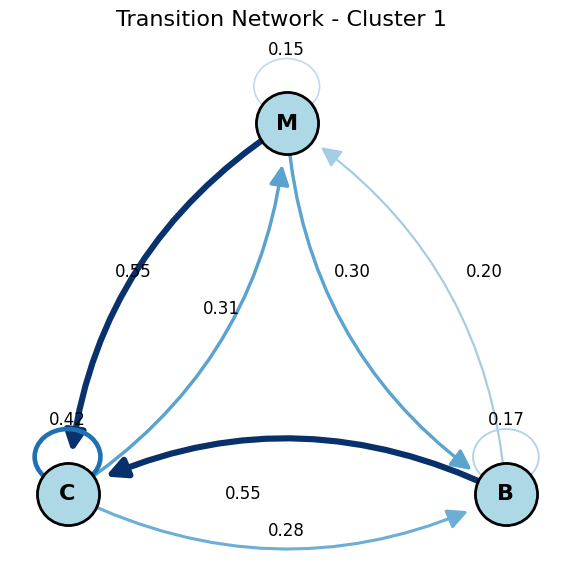

In [193]:
cluster_mean_probs = markov_df[markov_df['Cluster'] == 1][X_cluster.columns].mean()
matrix = pd.DataFrame(
    data=cluster_mean_probs.values.reshape(3, 3),
    index=['M', 'C', 'B'],
    columns=['M', 'C', 'B']
)

plot_transition_network_final_clean(matrix, title='Transition Network - Cluster 1', save_path='cluster_0_network_final.svg')


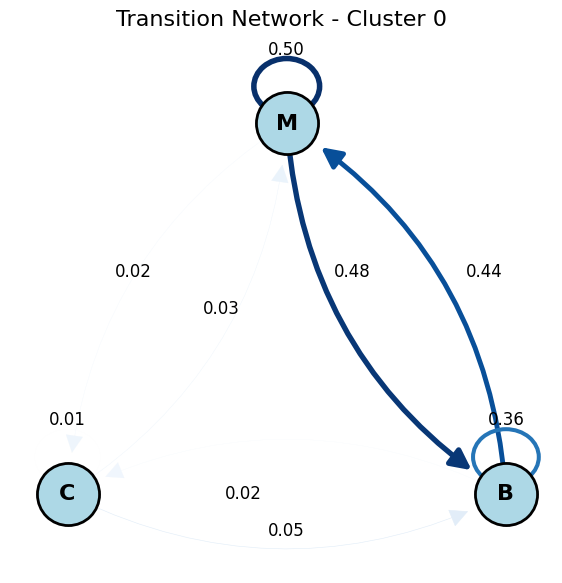

In [192]:
cluster_mean_probs = markov_df[markov_df['Cluster'] == 0][X_cluster.columns].mean()
matrix = pd.DataFrame(
    data=cluster_mean_probs.values.reshape(3, 3),
    index=['M', 'C', 'B'],
    columns=['M', 'C', 'B']
)

plot_transition_network_final_clean(matrix, title='Transition Network - Cluster 0', save_path='cluster_0_network_final.svg')


In [206]:
df_all = markov_df.merge(df_all_reg, on=["PATIENT_ID", "TYPE_CODE", "T0", "T1", "DIFF"])

In [212]:
cluster_mean_probs_0 = df_all[df_all['Cluster'] == 0]["Total_transitions"].mean()
cluster_mean_probs_1 = df_all[df_all['Cluster'] == 1]["Total_transitions"].mean()

In [214]:
cluster_mean_probs_1

62.15384615384615